# Preliminaries

In [661]:
import numpy as np
import matplotlib.pylab as plt
from dissipationtheory.constants import ureg, epsilon0, qe
from numba import jit, int32, float64, complex128
import numba as nb
import scipy
import cProfile

In [2]:
from dissipationtheory.dissipation9a import CantileverModel, SampleModel1, SampleModel2, SampleModel3, SampleModel4, K, integrand3
from dissipationtheory.dissipation9a import isMetal
from dissipationtheory.dissipation9b import CantileverModelJit, SampleModel1Jit, SampleModel2Jit, SampleModel3Jit, SampleModel4Jit
from dissipationtheory.dissipation9b import integrand1jit, integrand2jit, integrand3jit, K_jit, Kunits_jit, Kmetal_jit, Kmetalunits_jit
from dissipationtheory.dissipation8c import twodimCobject as twodimCobject8c

In [3]:
THIS = 'dissipation-theory--Study-53--'
figs = {}
obj = {}
df = {}

In [4]:
Kp = np.array([[complex(1,0), 0, 0],
               [complex(0,1), 0, 0],
               [0, complex(1,0), 0],
               [0, complex(0,1), 0],
               [0, 0, complex(1,0)],
               [0, 0, complex(0,1)]])

# Test objects

We are most interested in a semi-infinite dielectric sample and a metal, so make a Type III and Type IV sample.  The Type III sample is a good test case for modeling Type I and Type II samples.

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(62, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(55, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(1000, 'nm')
)

In [6]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20, 0), ''),
    sigma = ureg.Quantity(1e-7, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(100, 'nm')
)
sample3_jit = SampleModel3Jit(**sample3.args())

In [7]:
sample4 = SampleModel4(
    cantilever = cantilever,
    z_r = ureg.Quantity(100, 'nm')
)
sample4_jit = SampleModel4Jit(**sample4.args())

# Define a new and improved `twodimCobject`

In [8]:
class twodimCobjectA(twodimCobject8c):

    def __init__(self, sample):
        """Here sample is a SampleModel1Jit, SampleModel2Jit, 
        SampleModel3Jit, or SampleModel4Jit object."""

        self.sample = sample

        self.Vr = ureg.Quantity(1, 'V')
        self.zr = ureg.Quantity(sample.z_r, 'm')
        
        self.cG = (qe / (4 * np.pi * epsilon0 * self.Vr * self.zr)).to('dimensionless').magnitude
        self.cGinv = 1/self.cG

    def addsphere(self, h, N, M, theta_start=-np.pi/2, theta_stop=3*np.pi/2, theta_endpoint=False):
        """Model a sphere of radius $r$ above a ground plane, with a tip-sample
        separation of $h$.  Create image-charge points $r_j$ and voltage-test 
        points $r_k$.  The $N$ image-charge points are placed along a vertical
        line extending from $h + 0.1 r$ to $h + 1.90 r$. The $M$ voltage-test 
        points are located uniformly around the sphere, starting at the south 
        pole, $\theta = -\pi/2$, and rotating counter clockwise. Initialize the
        values of the image charges at 1.0.  Creates two arrays: 
        (a) self.rk, the voltage-test points, and (b) self.rj, the image-charge
        points, with the coordinates in nanometers. 
        """

        # read from sample.cantilever object
        r = ureg.Quantity(self.sample.cantilever.R, 'm').to('nm').magnitude

        # convert to nm and strip units
        h = h.to('nm').magnitude
        
        # charge locations
        delta_array = np.linspace(start=-0.90, stop=0.90, endpoint=True, num=N)
        self.rj = np.array([[0, 0, h + r + r * delta] for  delta in delta_array])

        # voltage-test locations
        theta_array = np.linspace(start=theta_start, stop=theta_stop, endpoint=theta_endpoint, num=M)
        self.rk = np.array([[r * np.cos(theta), 0, h + r + r * np.sin(theta)] for theta in theta_array])
        
        # save these
        self.info = {'type': 'sphere', 
                     'r [nm]': r, 
                     'h [nm]': h, 
                     'N': N,
                     'M': M }

        self.title1 = f'sphere, $r$ = {r:0.1f} nm, $h$ = {h:0.1f} nm, $N$ = {N:d} image charges, $M$ = {M:d} test points'
        self.title2 = ''

        # initialize the results, useful for plotting
        self.results = {
            'alpha': 0, 
            'q': np.ones(N),
            'S': np.ones(N),
            'Sinv': np.ones(N),
            'cn': 0, 
            'V': np.zeros(M)}    

Do code development on a computation for a Type IV sample, a metal.

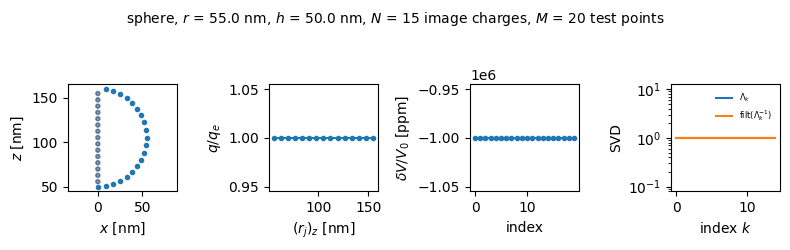

In [9]:
obj['IV'] = twodimCobjectA(sample4_jit)

params = {'h': ureg.Quantity(50, 'nm'),  # tip-sample separation
          'N': 15,                       # no. of image charges
          'M': 20,                       # no. voltage test points
          'theta_stop': np.pi/2,         # voltage-test points final angle 
          'theta_endpoint': False}       # endpoint at the final angle? 

obj['IV'].addsphere(**params)
_ = obj['IV'].plot()

Explore ways to create a Coulomb Green's function matrix rapidly.  \
The one-line function below uses the numpy `np.linalg.norm` to compute the Euclidean distance between two points.

In [10]:
def Kcoulomb(location1, location2):
    """Returns the Coulomb potential Green's function. 
    Here location1 and location2 is each a vector of components 
    representing normalized distances."""
    
    return complex(1,0) / np.linalg.norm(location1 - location2)

A shorthand for the two matrices. \
For the computations below, we need the distances in meters instead of nanometers.

In [11]:
rj = obj['IV'].rj * 1e-9
rk = obj['IV'].rk * 1e-9

Apply the `Kcoulomb` function to two unitless `rj` and `rk` matrices using a *list comprehension*.

In [12]:
Rj = rj / obj['IV'].sample.z_r
Rk = rk / obj['IV'].sample.z_r

In [13]:
%%timeit
np.array([[Kcoulomb(rj,rk) for rj in Rj] for rk in Rk])

2.44 ms ± 568 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Write a function to do this all in one step. \
Assume we feed the function **normalized unitless matrices**, the `Rk` and `Rj` computed above. 

In [14]:
def coulombmatrix(Rj, Rk):
    """The Coulomb potential Green's function matrix."""
    return np.array([[complex(1,0) / np.linalg.norm(rj - rk) for rj in Rj] for rk in Rk])

In [15]:
coulombmatrix(Rj,Rk).shape

(20, 15)

In [16]:
%%timeit
coulombmatrix(Rj,Rk)

2.12 ms ± 507 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Try `jit` compiling to see if the list comprehension loops can be sped up.  Read the manual [here](https://numba.pydata.org/numba-doc/0.28.1/reference/numpysupported.html) listing the `numpy` features supported by `jit`.  The function `numpy.linalg.norm` is partially supported.  I am not using any of the functions' advanced features, so I would expect it to compile.  It does, as the following example shows:

In [17]:
@jit(nopython=True)
def coulomb_jit(rj, rk):
    return 1/np.linalg.norm(rj - rk)

In [18]:
coulomb_jit(Rj[0], Rk[0])

18.1818181818182

Generalize the Coulomb *function* to a Coulomb *matrix*, however, and the compilation fails. \
Actually the function definition succeeds, but calling the function fails.

In [19]:
@jit(nopython=True)
def coulombmatrix_jit(Rj, Rk):
    """The Coulomb potential Green's function matrix."""
    return np.array([[1 / np.linalg.norm(rj - rk) for rj in Rj] for rk in Rk])

# coulombmatrix_jit(Rj, Rk)

The problem is the double list comprehension I think. \
Make a version of the matrix-generating function that uses loops.

In [20]:
np.zeros((len(Rk),len(Rj))).shape

(20, 15)

In [21]:
def coulombmatrix_jit(Rj, Rk):
    """The Coulomb potential Green's function matrix."""

    result = np.zeros((len(Rk),len(Rj)))
    for k, rk in enumerate(Rk):
        for j, rj in enumerate(Rj):
            result[k,j] = 1 / np.linalg.norm(rj - rk)
    return result

To make sure we have set up the loop right, check that we got the same answer as before.

In [22]:
np.allclose(coulombmatrix(Rj,Rk), coulombmatrix_jit(Rj,Rk))

True

Surprisingly, the function is only slightly slower that with a list comprehension.

In [23]:
%%timeit
coulombmatrix_jit(Rj, Rk)

2.43 ms ± 529 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now try compiling the above function.  The compilation is successful!

In [24]:
@jit(nopython=True)
def coulombmatrix_jit(Rj, Rk):
    """The Coulomb potential Green's function matrix."""

    result = np.zeros((len(Rk),len(Rj)))
    for k, rk in enumerate(Rk):
        for j, rj in enumerate(Rj):
            result[k,j] = 1 / np.linalg.norm(rj - rk)
    return result

In [25]:
np.allclose(coulombmatrix(Rj,Rk), coulombmatrix_jit(Rj,Rk))

True

The function runs in 0.2 ms compared to about 2 ms for the list-comprehension version. \
Conclude that **compiling the coulomb-matrix function gets us a factor of 10 speedup**.

In [26]:
%%timeit
coulombmatrix_jit(Rj, Rk)

141 μs ± 16 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Now let's see if we can make an analogous compiled function that returns the three matrices $K_0$, $K_1$, and $K_2$. \
For a metal, we need to call `Kmetal_jit`, wheareas for a Type I, II, or III sample we need to call `K_jit`. \
These two functions take a different number of parameters.

First, make a helper function that returns the integrand function appropriate for each sample.

In [27]:
def whichintegrand(sample):

    if sample.type == 3:
        integrand = integrand3jit
    elif sample.type == 2:
        integrand = integrand2jit
    elif sample.type == 1:
        integrand = integrand1jit
    else:
        raise ValueError('Uknown sample type =', sample.type, "sample = ", sample)

    return integrand

In [28]:
 whichintegrand(sample3_jit)

CPUDispatcher(<function integrand3jit at 0x128f26170>)

Second, write a general `Kmatrix_jit` function that should work for both metals and semiconductors.

In [29]:
def Kmatrix_jit(sample, omega, Rj, Rk):
    """The Green's function matrices for an image charge."""

    K0mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))
    K1mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))
    K2mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))

    if isMetal(sample):
    
        for k, rk in enumerate(Rk):
            for j, rj in enumerate(Rj):
                K0mat[k,j], K1mat[k,j], K2mat[k,j] = Kmetal_jit(sample, rj, rk)
        return K0mat, K1mat, K2mat

    else:

        integrand = whichintegrand(sample)
        for k, rk in enumerate(Rk):
            for j, rj in enumerate(Rj):
                K0mat[k,j], K1mat[k,j], K2mat[k,j] = K_jit(integrand, sample, omega, rj, rk)
        return K0mat, K1mat, K2mat        

Try a metal:

In [30]:
K0mat, K1mat, K2mat = Kmatrix_jit(sample4_jit, 0., rj, rk)

In [31]:
K0mat[0]

array([0.9478673 -0.j, 0.88832487-0.j, 0.8358209 -0.j, 0.789177  -0.j,
       0.74746396-0.j, 0.70993915-0.j, 0.67600193-0.j, 0.64516129-0.j,
       0.6170119 -0.j, 0.59121622-0.j, 0.56749088-0.j, 0.54559626-0.j,
       0.52532833-0.j, 0.5065123 -0.j, 0.48899756-0.j])

In [32]:
%%timeit
K0mat, K1mat, K2mat = Kmatrix_jit(sample4_jit, 0., rj, rk)

944 μs ± 13.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This is reasonably fast, about 1 ms.

Try a semi-infinite semiconductor:

In [33]:
K0mat, K1mat, K2mat = Kmatrix_jit(sample3_jit, 0., rj, rk)

In [34]:
K0mat[0]

array([0.88862101+0.j, 0.8340108 +0.j, 0.78580732+0.j, 0.74294108+0.j,
       0.70456841+0.j, 0.67001482+0.j, 0.6387346 +0.j, 0.61028146+0.j,
       0.58428686+0.j, 0.56044376+0.j, 0.53849433+0.j, 0.51822042+0.j,
       0.49943623+0.j, 0.48198251+0.j, 0.46572198+0.j])

In [35]:
%%timeit
K0mat, K1mat, K2mat = Kmatrix_jit(sample3_jit, 0., rj, rk)

999 ms ± 35.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is now super slow, 1 to 1.7s.  Ouch!

What about a list comprehension?

In [36]:
result = np.array([[K_jit(integrand3jit, sample3_jit, 0., rje, rke) for rje in rj] for rke in rk])
K0mat, K1mat, K2mat = result[:,:,0], result[:,:,1], result[:,:,2]
K0mat[0]

array([0.88862101+0.j, 0.8340108 +0.j, 0.78580732+0.j, 0.74294108+0.j,
       0.70456841+0.j, 0.67001482+0.j, 0.6387346 +0.j, 0.61028146+0.j,
       0.58428686+0.j, 0.56044376+0.j, 0.53849433+0.j, 0.51822042+0.j,
       0.49943623+0.j, 0.48198251+0.j, 0.46572198+0.j])

In [37]:
%%timeit
result = np.array([[K_jit(integrand3jit, sample3_jit, 0., rje, rke) for rje in rj] for rke in rk])

1.23 s ± 204 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


See below; a single function call to `K_jit` function for a Type III sample takes about 3.6 ms.  \
Estimate that $20 \times 15$ function calls would take 1.5s. \
This estimate is within a factor of two of the double list comprehension execution time above.

In [38]:
%%timeit
K_jit(integrand3jit, sample3_jit, 0., rj[0], rk[0])

4.42 ms ± 437 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The list comprehension is slightly faster than the function with loops, but not by much.

**Using an uncompiled loop to generate the K matrix for a semiconductor is painfully slow.**

Now try compiling the function.  Try this for a metal first.

In [39]:
@jit(nopython=True)
def Kmatrix_jit(sample, Rj, Rk):
    """The Green's function matrices for an image charge."""

    K0mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))
    K1mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))
    K2mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))
    
    for k, rk in enumerate(Rk):
        for j, rj in enumerate(Rj):
            K0mat[k,j], K1mat[k,j], K2mat[k,j] = Kmetal_jit(sample, rj, rk)
    return K0mat, K1mat, K2mat

In [40]:
K0mat, K1mat, K2mat = Kmatrix_jit(sample4_jit, rj, rk)
K0mat[0]

array([0.9478673 -0.j, 0.88832487-0.j, 0.8358209 -0.j, 0.789177  -0.j,
       0.74746396-0.j, 0.70993915-0.j, 0.67600193-0.j, 0.64516129-0.j,
       0.6170119 -0.j, 0.59121622-0.j, 0.56749088-0.j, 0.54559626-0.j,
       0.52532833-0.j, 0.5065123 -0.j, 0.48899756-0.j])

The compiling the function has sped the matrix-generation time from 1.2 ms to 0.2 ms, a factor of six speedup.

In [41]:
%%timeit
K0mat, K1mat, K2mat = Kmatrix_jit(sample4_jit, rj, rk)

289 μs ± 59 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**We can make a blazingly fast (0.2 ms) compiled function to generate the K matrix for a metal.**



Now try writing a function appropriate for a semiconductor that we can likewise compile.  Assume a Type III sample to start.

In [42]:
@jit(nopython=True)
def Kmatrix_jit(sample, omega, Rj, Rk):
    """The Green's function matrices for an image charge."""

    K0mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))
    K1mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))
    K2mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))
    
    for k, rk in enumerate(Rk):
        for j, rj in enumerate(Rj):
            K0mat[k,j], K1mat[k,j], K2mat[k,j] = K_jit(integrand3jit, sample, omega, rj, rk)
    return K0mat, K1mat, K2mat   

The following call fails with the error

    TypingError: Failed in nopython mode pipeline (step: nopython frontend)
    Untyped global name 'K_jit': Cannot determine Numba type of <class 'function'>

In [43]:
# K0mat, K1mat, K2mat = Kmatrix_jit(sample3_jit, 0., rj, rk)

Ok, try writing the function by eliminating the call to `K_jit`, which is actually an uncompiled function.

In [44]:
@jit(nopython=True)
def Kmatrix_jit(sample, omega, Rj, Rk):
    """The Green's function matrices for an image charge."""

    K0mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))
    K1mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))
    K2mat = complex(1,0) * np.zeros((len(Rk),len(Rj)))
    
    for k, rk in enumerate(Rk):
        for j, rj in enumerate(Rj):
            integrals = scipy.integrate.quad_vec(integrand3jit, 0., np.inf, args=(sample, omega,  rj, rk))[0]
            K0mat[k,j], K1mat[k,j], K2mat[k,j] = integrals @ Kp
    return K0mat, K1mat, K2mat  

The following call fails with the error

    TypingError: Failed in nopython mode pipeline (step: nopython frontend)
    Unknown attribute 'quad_vec' of type Module(<module 'scipy.integrate' from '/Users/jam99/Library/Caches/pypoetry/virtualenvs/dissipationtheory-Uvi85QQO-py3.10/lib/python3.10/site-packages/scipy/integrate/__init__.py'>)

In [45]:
# K0mat, K1mat, K2mat = Kmatrix_jit(sample3_jit, 0., rj, rk)

Read some more.  If I Google "error with numba and scipy.integrate.quad" then the Google AI answers "While Numba excels at optimizing numerical Python code, it cannot directly compile calls into external libraries like scipy.integrate.quad within nopython mode. This is because quad is implemented using compiled Fortran code (QUADPACK), which Numba cannot directly optimize or inline." and "Numba's numba-scipy package provides support for a subset of SciPy functions, primarily those in scipy.special. scipy.integrate.quad is not currently included in this direct support."

Yet I find this example [here](https://numba.discourse.group/t/overload-scipy-integrate-quad-changing-values/3011) where someone used `scipy.integrate.quad` in a jitted function.

In [46]:
from numba import jit, objmode
from scipy.integrate import quad as sp_quad
import numpy as np

@jit(nopython=True)
def test_func(a, b):
    with objmode(result='float64'):  # annotate return type
        result, _ = sp_quad(np.sin, a, b)
    return result

a = 0.0
b = np.pi
result = test_func(a, b)
print("Result of the integration:", result)

Result of the integration: 2.0


An example function call:

In [47]:
result, _ = scipy.integrate.quad_vec(integrand3jit, 0., np.inf, args=(sample3_jit, 1.,  rj[0], rk[0]))
result

array([ 8.88620947e-01, -3.91407395e-05,  8.23619423e-01, -8.24356615e-06,
        1.54950169e+00, -3.59371338e-06])

Modify the code above.  This code **fails spectacularly** with the error

    LoweringError: Failed in nopython mode pipeline (step: Handle with contexts)
    Failed in nopython mode pipeline (step: native lowering)
    cannot pickle 'SampleModel3Jit' object

In [48]:
@jit(nopython=True)
def test_func(rj,rk):
    with objmode(result='float64[:]'):
        result, _ = scipy.integrate.quad_vec(integrand3jit, 0., np.inf, args=(sample3_jit, 0.,  rj[0], rk[0]))
    return result

# result = test_func(rj,rk)
# result

I interpret this error as follows: the compiler does not know how to handle the function `sample3_jit` object, which gets passed to the compiled `integrand3jit` function in the `scipy.integrate.quad_vec` function call.

Computing the $K_n$ matrices presently takes 1 to 2 seconds.  We should be able to reduce the execution time to 0.1 to 0.2 seconds by compiling the matrix-generating function.  However, I have not been able to get the compilation to work.  The problem seems to be the `sample3_jit` object being passed to `integrand3jit`.

# Try to write a compiled function with `scipy.integrate.quad_vec` in a loop

Make a dummy function to play with that returns a 2-component vector and gets fed three parameters, two of them vectors.

In [288]:
@jit(float64[:](float64,
             float64,
             float64[:],
             float64[:]), nopython=True)

def func(y, zr, location1, location2):

    rhoX = (location1[0] - location2[0])/ zr
    rhoY = (location1[1] - location2[1])/ zr
    
    argument = y * np.sqrt(rhoX**2 + rhoY**2)
    exponent = y * (location1[2] + location2[2])/ zr

    integrand = np.array([1, y]) * scipy.special.j0(argument) * np.exp(-1 * exponent)
    return integrand

The execution time is 17.4 μs ± 1.45 μs per loop for the uncompiled function. \
The execution time is 2.89 μs ± 131 ns per loop  for the compiled function.

In [220]:
%%timeit
func(1.5, sample3_jit.z_r, rj[0], rk[0])

2.89 μs ± 131 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Now put the function in an loop.

In [254]:
def test_func(zr, rk, rj):

    K0mat = complex(1,0) * np.zeros((len(rk),len(rj)))
    K1mat = complex(1,0) * np.zeros((len(rk),len(rj)))
    
    for k, rke in enumerate(rk):
        for j, rje in enumerate(rj):
            K0mat[k,j], K1mat[k,j] = scipy.integrate.quad_vec(func, 0., np.inf, args=(zr, rje, rke))[0]

    return K0mat, K1mat

In [255]:
K0mat, K1mat = test_func(sample3_jit.z_r, rj, rk)
K0mat[0]

array([0.9478673 +0.j, 0.93874525+0.j, 0.91308602+0.j, 0.87522433+0.j,
       0.83039596+0.j, 0.7832297 +0.j, 0.73705154+0.j, 0.69387502+0.j,
       0.65470668+0.j, 0.61989479+0.j, 0.5894066 +0.j, 0.5630154 +0.j,
       0.54041467+0.j, 0.52128283+0.j, 0.5053174 +0.j, 0.4922513 +0.j,
       0.48185948+0.j, 0.47396042+0.j, 0.4684154 +0.j, 0.46512691+0.j])

In [256]:
%%timeit
K0mat, K1mat = test_func(sample3_jit.z_r, rj, rk)

746 ms ± 30.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Read about `objmode` [here](https://numba.pydata.org/numba-doc/dev/user/withobjmode.html) in the numba manual.  There is a warning: "This feature can be easily mis-used. Users should first consider alternative approaches to achieve their intended goal before using this feature."

In [307]:
@jit(nopython=True)
def test_func(zr, rj, rk):
    with objmode(K0mat='complex128[:,:]'):

        K0mat = complex(1,0) * np.zeros((len(rk),len(rj)))
        
        for k, rke in enumerate(rk):
            for j, rje in enumerate(rj):
                K0mat[k,j], _ = scipy.integrate.quad_vec(func, 0., np.inf, args=(zr, rje, rke))[0]

        return K0mat

In [308]:
K0mat = test_func(sample3_jit.z_r, rj, rk)
(K0mat[0][0])

(0.9478672985781992+0j)

In [309]:
%%timeit
K0mat = test_func(sample3_jit.z_r, rj, rk)

1.34 s ± 204 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**I succeeded in compiling a function with `scipy.integrate.quad_vec` in a loop, but the function runs slower than uncompiled Python (800 ms)!**

What about brute-force Riemannian integration?

In [314]:
def test_func(zr, rj, rk):
    
    y = np.linspace(0., 30., 200)
    K0mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    K1mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    
    dy = y[1] - y[0]
    
    for k, rke in enumerate(rk):
        for j, rje in enumerate(rj):
            for m, y_ in enumerate(y):
                K0mat[k,j,m], K1mat[k,j,m] = func(y_, zr, rje, rke)

    return dy * K0mat.sum(axis=2), dy * K1mat.sum(axis=2)

In [315]:
K0mat, K1mat = test_func(sample3_jit.z_r, rj, rk)
(K0mat[0][0], K1mat[0][0])

((1.0252413967522305+0j), (0.8965609170784948+0j))

The actual answer is 0.9478673, so we are 5% off.  However, for 200 integration points, the execution is faster, under 300 ms.

In [316]:
%%timeit
K0mat, K1mat = test_func(sample3_jit.z_r, rj, rk)

285 ms ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [323]:
@jit(nopython=True)

def test_func(zr, rj, rk):
    
    y = np.linspace(0., 30., 200)
    K0mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    K1mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    
    dy = y[1] - y[0]
    
    for k, rke in enumerate(rk):
        for j, rje in enumerate(rj):
            for m, y_ in enumerate(y):
                K0mat[k,j,m], K1mat[k,j,m] = func(y_, zr, rje, rke)

    return dy * K0mat.sum(axis=2), dy * K1mat.sum(axis=2)

In [324]:
K0mat, K1mat = test_func(sample3_jit.z_r, rj, rk)
(K0mat[0][0], K1mat[0][0])

((1.0252413967522311+0j), (0.8965609170784938+0j))

In [325]:
%%timeit
K0mat, K1mat = test_func(sample3_jit.z_r, rj, rk)

17.3 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


**With 200 integration points, the compiled Riemannian integration routine runs in only 20 ms. This would enable least-squares fitting.**

So while `scipy.integrate.quad_vec` is certainly more accurate, brute-force Riemannian integration compiles better.  \
However, in the above example, it seems quite inaccurate. \
To make Riemannian integration work, I would need to carefully tweak the $y$ spacing.

The integrand has a decaying $e^{-y Z}$ term. \
This suggests using logarithmically-spaced $y$ values intead of linearly-spaced $y$ values, with the upper range a multiple of $Z$. \
And we can do better than simple Trapezoidal integration. \
See, for example, the Newton-Cotes formulas ([Wikipedia](https://en.wikipedia.org/wiki/Newton%E2%80%93Cotes_formulas)).

# Could we really beat `scipy.integrate` with a Riemannian sum?

Good news: `Kmetal_jit` is suitably fast.  \
Bad new: `K_jit` is unsuitably slow!

In [68]:
%%timeit
Kmetal_jit(sample4_jit, rj[0], rk[0])

3.99 μs ± 1.01 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [69]:
%%timeit
K_jit(integrand3jit, sample3_jit, 1., rj[0], rk[0])

5.45 ms ± 798 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


How long does *one* function call to `integrand3jit` take?

In [74]:
%%timeit
integrand3jit(1.5, sample3_jit, 1., rj[0], rk[0])

3.51 μs ± 794 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


I would expect `K_jit` to be 50 to 100 times slower than `Kmetal_jit`, because there is a numerical integration involved. \
Yet, looking above, the function `K_jit` is more than ~1000 times slower than `Kmetal_jit`. \
Why is it so slow?  It is all the special functions?

Could I speed up the integration by avoiding `integrate.quad_vec` and doing a brute-force Riemannian sum?

Look at the integrand.  As the integration variable goes from 0 to 10, plot the *absolute value* of the various $K$ integrals.  Plot with a logarithmic $y$ axis, because the imaginary parts are very small (and negative).

(100, 6)


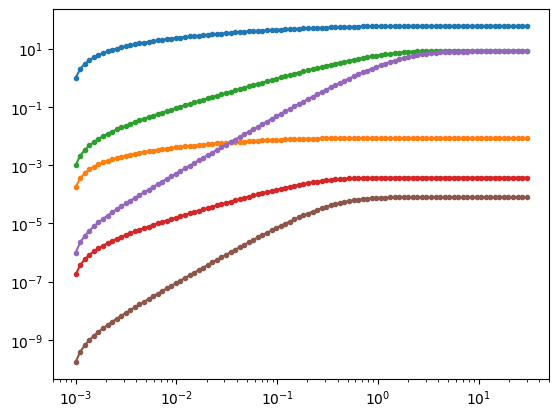

In [346]:
# y_vals = np.linspace(0,30,500)
y_vals = np.logspace(np.log10(0.001),np.log10(30), 100)

integrand3_vals = np.array([integrand3jit(y, sample3_jit, 1., rj[0], rk[0]) for y in y_vals])
print(integrand3_vals.shape)

plt.loglog(y_vals, np.abs(np.cumsum(integrand3_vals,axis=0)), '.-')
plt.show()

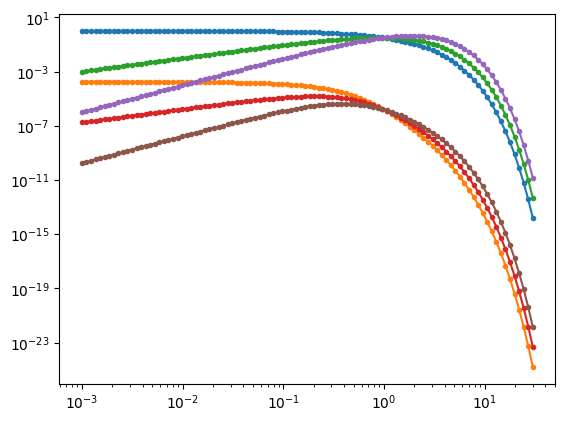

In [347]:
plt.loglog(y_vals, np.abs(integrand3_vals), '.-')
plt.show()

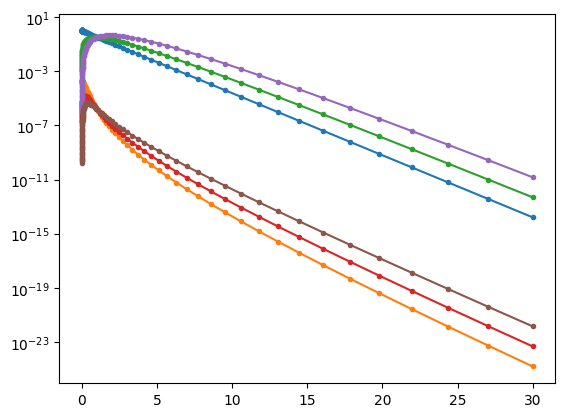

In [348]:
plt.semilogy(y_vals, np.abs(integrand3_vals), '.-')
plt.show()

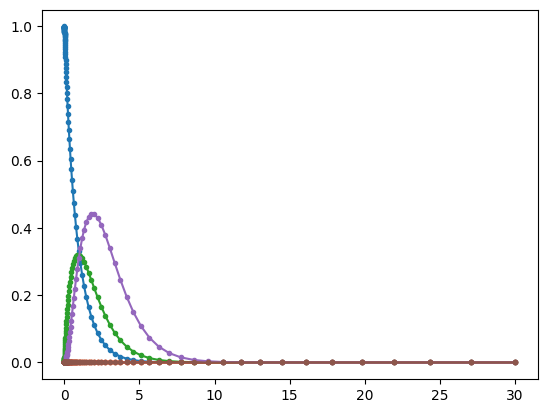

In [349]:
plt.plot(y_vals, np.abs(integrand3_vals), '.-')
plt.show()

# Try to speed up `integrand3jit`

To figure out whether the custom class `SampleModel3Jit` is slowing us down, write a function where the sample values are *hardwired* into the function.

In [326]:
@jit(float64[:](float64,
             float64,
             float64[:],
             float64[:]), nopython=True)

def integrand3jitfast(y, omega, location1, location2):
    """Theta function for a Sample III object, a semi-infinite dielectric.
    
    In the code below, `y` is the unitless integration variable."""

    es = complex(20.0, 0.)
    zr = 100.0e-9
    omega0 = 389557.
    kD = 26456583.
        
    Omega = omega/omega0
    k_over_eta = y / np.sqrt(y**2 + (zr * kD)**2 * (1/es + complex(0,1) * Omega)) # depends on y

    p0 = 1 + complex(0,1) * es * Omega
    p1 = k_over_eta / (es * p0)          # depends on y
    p6 = complex(0,1) * Omega / p0

    theta_norm = p6 + p1
    rp = (1 - theta_norm) / (1 + theta_norm)

    rhoX = (location1[0] - location2[0])/ zr
    rhoY = (location1[1] - location2[1])/ zr
    argument = y * np.sqrt(rhoX**2 + rhoY**2)
    exponent = y * (location1[2] + location2[2])/ zr

    integrand = np.array([       np.real(rp),        np.imag(rp), 
                          y    * np.real(rp), y    * np.imag(rp),
                          y**2 * np.real(rp), y**2 * np.imag(rp)]) * scipy.special.j0(argument) * np.exp(-1 * exponent)

    return integrand

In [327]:
integrand3jitfast(1.5, 1., rj[0], rk[0])

array([ 1.87197014e-01, -6.86243281e-09,  2.80795521e-01, -1.02936492e-08,
        4.21193282e-01, -1.54404738e-08])

Now time the execution.

In [328]:
%%timeit
integrand3jitfast(1.5, 1., rj[0], rk[0])

2.78 μs ± 398 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The run time is only slightly faster than the 3.51 μs ± 794 ns per loop seen above.

Conclude that the custom class `SampleModel3Jit` is not slowing us down too much.

Let's see how much faster it gets if we move *all possible computations* outside the function.  \
That is, keep only the computations involving $y$ inside the integrand.

In [193]:
es = complex(20.0, 0.)
zr = 100.0e-9
kD = 26456583.
zrkD2 = (zr * kD)**2

omega = 1.0
omega0 = 389557.
Omega = omega/omega0

p0 = 1 + complex(0,1) * es * Omega
p6 = complex(0,1) * Omega / p0

rhoX = (rj[0][0] - rk[0][0])/ zr
rhoY = (rj[0][1] - rk[0][1])/ zr
rho = np.sqrt(rhoX**2 + rhoY**2)
Z = (rj[0][2] + rk[0][2])/ zr

(1.5, Omega, es, zrkD2, p0, p6, rho, Z, rj[0], rk[0])

(1.5,
 2.5670184337593727e-06,
 (20+0j),
 6.99950784035889,
 (1+5.134036867518745e-05j),
 (1.3179167243782755e-10+2.5670184269931392e-06j),
 3.367778697655221e-17,
 1.0550000000000002,
 array([0.00e+00, 0.00e+00, 5.55e-08]),
 array([3.3677787e-24, 0.0000000e+00, 5.0000000e-08]))

In [194]:
@jit(float64[:](float64,  # y
             float64,     # Omega
             complex128,  # es
             float64,     # zrkD2
             complex128,  # p0
             complex128,  # p6
             float64,     # rho
             float64,     # Z   
             float64[:],
             float64[:]), nopython=True)

def integrand3jitfast(y, Omega, es, zrkD2, p0, p6, rho, Z, location1, location2):
    """Theta function for a Sample III object, a semi-infinite dielectric.
    
    In the code below, `y` is the unitless integration variable."""

    k_over_eta = y / np.sqrt(y**2 + zrkD2 * (1/es + complex(0,1) * Omega))
    p1 = k_over_eta / (es * p0)
    theta_norm = p6 + p1
    rp = (1 - theta_norm) / (1 + theta_norm)

    integrand = np.array([       np.real(rp),        np.imag(rp), 
                          y    * np.real(rp), y    * np.imag(rp),
                          y**2 * np.real(rp), y**2 * np.imag(rp)]) * scipy.special.j0(y * rho) * np.exp(-y * Z)

    return integrand

In [200]:
integrand3jitfast(1.5, Omega, es, zrkD2, p0, p6, rho, Z, rj[0], rk[0])

array([ 1.87197014e-01, -6.86243281e-09,  2.80795521e-01, -1.02936492e-08,
        4.21193282e-01, -1.54404738e-08])

Now time it.

In [201]:
%%timeit
integrand3jitfast(1.5, Omega, es, zrkD2, p0, p6, rho, Z, rj[0], rk[0])

2.22 μs ± 61.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The execution is only slightly faster, and sometimes slower, than the 2.86 μs ± 454 ns per loop seen above! \
Surprising, because I have moved a lot of the computations outside the function. \
Is passing variables in and out of the function is time-consuming?

**Moving computations outside the `integrand3jitfast` function resulted in essentially no decrease in execution time.**

# Explore really accurate Riemannian integration

Some helper functions.

In [608]:
def disentangle(temp):
    """Convert a complex 3-vector into a real 6-vector"""

    return np.array([temp[0].real, temp[0].imag,
                 temp[1].real, temp[1].imag,
                 temp[2].real, temp[2].imag])

In [609]:
disentangle(np.array([complex(1,2), complex(3,4), complex(5,6)]))

array([1., 2., 3., 4., 5., 6.])

In [610]:
def compare(a,b):
    epsilon_rel = (a-b) / a
    epsilon_pct = 100 * (a-b) / a
    print("  reference  value      relative percent ")
    print("  ========== ========== ======== ========")
    for k, (a_, b_, epsilon_rel_, epsilon_pct_) in enumerate(zip(a, b, epsilon_rel, epsilon_pct)):
        print("{:d} {:+1.7f} {:+1.7f} {:+1.1e} {:+1.3f}".format(k, a_, b_, epsilon_rel_, epsilon_pct_))

In [611]:
compare(np.array([1.0, 1.0]), np.array([1.01, 0.98]))

  reference  value      relative percent 
  ========== ========== ======== ========
0 +1.0000000 +1.0100000 -1.0e-02 -1.000
1 +1.0000000 +0.9800000 +2.0e-02 +2.000


Here is a representative calculation.

In [612]:
v0 = disentangle(K_jit(integrand3jit, sample3_jit, 1.0e5, rj[0], rk[0])) 
v0

array([ 8.57635835e-01, -4.42486634e-04,  8.12958063e-01, -3.76874146e-04,
        1.54120487e+00, -6.31087354e-04])

Here is a brute-force integrator that just sums the numbers up and multiplies them by $\Delta y$.  \
Playing with the integration limits, $(0, 10)$, and the number of points, $1000$, I can get the errors under 1 percent. 

In [613]:
def integrator(sample, omega, rj, rk):
    
    y = np.linspace(0., 10., 1000)
    dy = np.diff(y)
    y = y[0:-1]
    
    result = complex(1,0) * np.zeros((6,len(y)))
    
    for m, y_ in enumerate(y):
        result[:,m] = integrand3jit(y_, sample3_jit, omega, rj, rk)

    return (dy * result).sum(axis=1) @ Kp

In [614]:
v1 = disentangle(integrator(sample3_jit, 1.0e5, rj[0], rk[0]))
v1

array([ 8.62149571e-01, -4.45053924e-04,  8.12703363e-01, -3.76857880e-04,
        1.53848010e+00, -6.30958062e-04])

In [615]:
compare(v0,v1)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.8576358 +0.8621496 -5.3e-03 -0.526
1 -0.0004425 -0.0004451 -5.8e-03 -0.580
2 +0.8129581 +0.8127034 +3.1e-04 +0.031
3 -0.0003769 -0.0003769 +4.3e-05 +0.004
4 +1.5412049 +1.5384801 +1.8e-03 +0.177
5 -0.0006311 -0.0006310 +2.0e-04 +0.020


Can I get 1% errors using only 100 points? \
Try a logarithmically spaced $y$ axis.

In [616]:
def integrator(sample, omega, rj, rk):
    
    y = np.logspace(np.log10(0.01), np.log10(20), 100)
    dy = np.diff(y)
    y = y[0:-1]
    
    result = complex(1,0) * np.zeros((6,len(y)))
    
    for m, y_ in enumerate(y):
        result[:,m] = integrand3jit(y_, sample3_jit, omega, rj, rk)

    return (dy * result).sum(axis=1) @ Kp

In [617]:
v2 = disentangle(integrator(sample3_jit, 1.0e5, rj[0], rk[0]))
v2

array([ 8.82416194e-01, -4.54822399e-04,  8.44937241e-01, -3.91694769e-04,
        1.60191213e+00, -6.55945722e-04])

In [618]:
compare(v0,v2)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.8576358 +0.8824162 -2.9e-02 -2.889
1 -0.0004425 -0.0004548 -2.8e-02 -2.788
2 +0.8129581 +0.8449372 -3.9e-02 -3.934
3 -0.0003769 -0.0003917 -3.9e-02 -3.933
4 +1.5412049 +1.6019121 -3.9e-02 -3.939
5 -0.0006311 -0.0006559 -3.9e-02 -3.939


The errors are actually worse with logarithmically space y-axis!

Try a fancier integration.  See the `scipy.integrate.newton_cotes` example code [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.newton_cotes.html).

In [619]:
from scipy.integrate import newton_cotes

In [620]:
def integrator(sample, omega, rj, rk):

    N = 30
    ymax = 30.
    
    y = np.linspace(0., ymax, N+1)
    an, _ = newton_cotes(N, 1)
    dy = ymax / N
    
    result = complex(1,0) * np.zeros((6,len(y)))
    for m, y_ in enumerate(y):
        result[:,m] = integrand3jit(y_, sample3_jit, omega, rj, rk)

    return dy * (an * result).sum(axis=1) @ Kp

In [621]:
v3 = disentangle(integrator(sample3_jit, 1.0e5, rj[0], rk[0]))
v3

array([ 8.57635822e-01, -4.42491949e-04,  8.12957866e-01, -3.76882169e-04,
        1.54120505e+00, -6.30833433e-04])

In [622]:
compare(v0,v3)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.8576358 +0.8576358 +1.5e-08 +0.000
1 -0.0004425 -0.0004425 -1.2e-05 -0.001
2 +0.8129581 +0.8129579 +2.4e-07 +0.000
3 -0.0003769 -0.0003769 -2.1e-05 -0.002
4 +1.5412049 +1.5412051 -1.2e-07 -0.000
5 -0.0006311 -0.0006308 +4.0e-04 +0.040


**Wow, `newton_cotes` integration rocks!  With $N = 30$ points, I am getting errors for the real parts in the 10's of ppm range.**

Use what we have learned to create the full matrix of $K_0$, $K_1$, and $K_2$ values. \
Do this first with a pure Python function.

In [732]:
def Kmatrix_jit(sample, omega, rj, rk):
    """The Green's function matrices for an image charge."""

    N = 30
    ymax = 30.
    
    y = np.linspace(0., ymax, N+1)
    an, _ = scipy.integrate.newton_cotes(N, 1)
    dy = ymax / N

    K0mat = complex(1,0) * np.zeros((len(Rk),len(Rj),len(y)))
    K1mat = complex(1,0) * np.zeros((len(Rk),len(Rj),len(y)))
    K2mat = complex(1,0) * np.zeros((len(Rk),len(Rj),len(y)))
    
    for k, rke in enumerate(rk):
        for j, rje in enumerate(rj):
            for m, y_ in enumerate(y):
                K0mat[k,j,m], K1mat[k,j,m], K2mat[k,j,m] = integrand3jit(y_, sample, omega, rje, rke) @ Kp
            
    return dy * (an * K0mat).sum(axis=2), \
           dy * (an * K1mat).sum(axis=2), \
           dy * (an * K2mat).sum(axis=2)

In [733]:
K0, K1, K2 = Kmatrix_jit(sample3_jit, 1.0e5, rj, rk)
v4 = disentangle(np.array([K0[0][0], K1[0][0], K2[0][0]]))

In [734]:
compare(v0,v4)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.8576358 +0.8576358 +1.5e-08 +0.000
1 -0.0004425 -0.0004425 -1.2e-05 -0.001
2 +0.8129581 +0.8129579 +2.4e-07 +0.000
3 -0.0003769 -0.0003769 -2.1e-05 -0.002
4 +1.5412049 +1.5412051 -1.2e-07 -0.000
5 -0.0006311 -0.0006308 +4.0e-04 +0.040


How fast is it?  Reasonably fast, under 200 ms.

In [648]:
%%timeit
K0, K1, K2 = Kmatrix_jit(sample3_jit, 1.0e5, rj, rk)

152 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Uncompiled, the above `Kmatrix_jit` function is about a factor of 5 faster than the analogous code using `scipy.integrate.quad_vec`.

Now try compiling it. 

See [this](https://stackoverflow.com/questions/30363253/multiple-output-and-numba-signatures) example of a `@jit` declaration for a function returning a tuple.


The following code fails to compile with the error

    TypingError: Failed in nopython mode pipeline (step: nopython frontend)
    Invalid use of type(CPUDispatcher(<function integrand3jit at 0x128f26170>)) with parameters

In [668]:
if 0:

    N = 30
    an, _ = scipy.integrate.newton_cotes(N, 1)
    
    @jit(nb.types.UniTuple(nb.complex128[:,:],3)(
        SampleModel3Jit.class_type.instance_type,
        nb.float64,
        nb.float64[:],
        nb.float64[:],
        nb.uint16,
        nb.float64[:]),nopython=True)
    
    def Kmatrix_jit(sample, omega, rj, rk, N, an):
        """The Green's function matrices for an image charge."""
    
        N = 30
        ymax = 30.    
        y = np.linspace(0., ymax, N+1)
        dy = ymax / N
    
        K0mat = complex(1,0) * np.zeros((len(Rk),len(Rj),len(y)))
        K1mat = complex(1,0) * np.zeros((len(Rk),len(Rj),len(y)))
        K2mat = complex(1,0) * np.zeros((len(Rk),len(Rj),len(y)))
        
        for k, rke in enumerate(rk):
            for j, rje in enumerate(rj):
                for m, y_ in enumerate(y):
                    K0mat[k,j,m], K1mat[k,j,m], K2mat[k,j,m] = integrand3jit(y_, sample, omega, rje, rke) @ Kp
                
        return dy * (an * K0mat).sum(axis=2), \
               dy * (an * K1mat).sum(axis=2), \
               dy * (an * K2mat).sum(axis=2)

In [670]:
if 0:
    K0, K1, K2 = Kmatrix_jit(sample3_jit, 1.0e5, rj, rk, N, an)
    v5 = disentangle(np.array([K0[0][0], K1[0][0], K2[0][0]]))

It looks like `jit` is having trouble with the function call to `integrand3jit`. \
Is this because it has a custom data type, `SampleModel3Jit`, as input? \
It should be possible to write a version of the `integrand3jit` function that takes only has "regular" inputs.

# Rewrite `integrand3jit` using Newton-Cotes integration

What sample parameters does the function `integrand3jit` really need? \
Extract them from the sample and put them in a dictionary.

In [693]:
def utility(sample):
    return {'es': sample.epsilon_s, 'zr': sample.z_r, 'omega0': sample.omega0, 'kD': sample.kD}

In [694]:
pars = utility(sample3_jit)
pars

{'es': (20+0j),
 'zr': 1.0000000000000001e-07,
 'omega0': 11294.09067373019,
 'kD': 26456583.416667342}

Rewrite `integrand3jit` so that the relevant sample properties get passed to the function, instead of the complicated sample objects. \
We do not have any complicated objects to pass, so `@jit` works out of the box.

In [711]:
@jit(nopython=True)

def integrand3jitnew(y, es, zr, omega0, kD, omega, location1, location2):
    """Integrand for a Sample III object, a semi-infinite dielectric.
    
    In the code below, `y` is the unitless integration variable.
    """

    Omega = omega/omega0
    k_over_eta = y / np.sqrt(y**2 + (zr * kD)**2 * (1/es + complex(0,1) * Omega)) # depends on y

    p0 = 1 + complex(0,1) * es * Omega
    p1 = k_over_eta / (es * p0)          # depends on y
    p6 = complex(0,1) * Omega / p0

    theta_norm = p6 + p1
    rp = (1 - theta_norm) / (1 + theta_norm)

    rhoX = (location1[0] - location2[0])/ zr
    rhoY = (location1[1] - location2[1])/ zr
    argument = y * np.sqrt(rhoX**2 + rhoY**2)
    exponent = y * (location1[2] + location2[2])/ zr

    integrand = np.array([       np.real(rp),        np.imag(rp), 
                          y    * np.real(rp), y    * np.imag(rp),
                          y**2 * np.real(rp), y**2 * np.imag(rp)]) * scipy.special.j0(argument) * np.exp(-1 * exponent)

    return integrand

Add to the sample-characteristics dictionary the value of `y` and the locations where we want the integral evaluated at.

In [793]:
vals = {'y': 1.5, 'omega': 1.0e5, 'location1': rj[0], 'location2': rk[0]}
pars = {**vals, **utility(sample3_jit)}
pars

{'y': 1.5,
 'omega': 100000.0,
 'location1': array([0.00e+00, 0.00e+00, 5.55e-08]),
 'location2': array([3.3677787e-24, 0.0000000e+00, 5.0000000e-08]),
 'es': (20+0j),
 'zr': 1.0000000000000001e-07,
 'omega0': 11294.09067373019,
 'kD': 26456583.416667342}

The function `integrand3jitnew` returns a 6-vector.

In [796]:
integrand3jitnew(**pars)

array([ 1.85907472e-01, -9.06966548e-05,  2.78861208e-01, -1.36044982e-04,
        4.18291812e-01, -2.04067473e-04])

The new `integrand3jitnew` function gives the same results as `integrand3jit`.  Yea!

In [717]:
compare(integrand3jit(1.5, sample3_jit, 1.0e5, rj[0], rk[0]),
        integrand3jitnew(**pars))

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.1859075 +0.1859075 +0.0e+00 +0.000
1 -0.0000907 -0.0000907 -0.0e+00 -0.000
2 +0.2788612 +0.2788612 +0.0e+00 +0.000
3 -0.0001360 -0.0001360 -0.0e+00 -0.000
4 +0.4182918 +0.4182918 +0.0e+00 +0.000
5 -0.0002041 -0.0002041 -0.0e+00 -0.000


What about execution time of `integrand3jitnew`? \
It's comparable to that of `integrand3jit`, and perhaps even a little faster.

In [720]:
%%timeit
integrand3jitnew(**pars)

2.92 μs ± 649 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [721]:
%%timeit
integrand3jit(1.5, sample3_jit, 1.0e5, rj[0], rk[0])

5.68 μs ± 1.1 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Now use the function in a revised version of `Kmatrix_jit`.

In [739]:
N = 30
an, _ = scipy.integrate.newton_cotes(N, 1)

In [801]:
def Kmatrix_jit(es, zr, omega0, kD, omega, rj, rk, N, an):
    """The Green's function matrices for an image charge."""

    N = 30
    ymax = 30.    
    y = np.linspace(0., ymax, N+1)
    dy = ymax / N

    K0mat = complex(1,0) * np.zeros((len(Rk),len(Rj),len(y)))
    K1mat = complex(1,0) * np.zeros((len(Rk),len(Rj),len(y)))
    K2mat = complex(1,0) * np.zeros((len(Rk),len(Rj),len(y)))
    
    for k, rke in enumerate(rk):
        for j, rje in enumerate(rj):
            for m, y_ in enumerate(y):
                
                K0mat[k,j,m], K1mat[k,j,m], K2mat[k,j,m] = integrand3jitnew(y_, es, zr, omega0, kD, omega, rje, rke) @ Kp
            
    return dy * (an * K0mat).sum(axis=2), \
           dy * (an * K1mat).sum(axis=2), \
           dy * (an * K2mat).sum(axis=2)

It's a little more klunky to call the function.

In [802]:
vals = {'omega': 1.0e5, 'rj': rj, 'rk': rk, 'N': N, 'an': an}
pars = {**vals, **utility(sample3_jit)}

K0, K1, K2 = Kmatrix_jit(**pars)
v6 = disentangle(np.array([K0[0][0], K1[0][0], K2[0][0]]))

We get the correct results.

In [803]:
compare(v0,v6)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.8576358 +0.8576358 +1.5e-08 +0.000
1 -0.0004425 -0.0004425 -1.2e-05 -0.001
2 +0.8129581 +0.8129579 +2.4e-07 +0.000
3 -0.0003769 -0.0003769 -2.1e-05 -0.002
4 +1.5412049 +1.5412051 -1.2e-07 -0.000
5 -0.0006311 -0.0006308 +4.0e-04 +0.040


Even uncompiled, the new function runs reasonably fast, less than 100 ms.

In [804]:
%%timeit
K0, K1, K2 = Kmatrix_jit(**pars)

88.4 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Ok, now try compiling it.  

Read the numba manual [here](https://numba.pydata.org/numba-doc/dev/user/jit.html).

The function below was developed by trial-and-error. \
Empirically, a number of things were neccessary to get the `Kmatrix_jit` function below to compile and run without errors: 

* let `jit` determine data types, that is, use a bare-bones `@jit(nopython=True)` decorator to force compilation (so-called lazy compilation);
* declare all matrices up front; and 
* avoid using complicated type casting in the code (see the two examples below).

**Example 1**.  Instead of 

    K0mat[k,j,m], K1mat[k,j,m], K2mat[k,j,m] = integrand3jitnew(y_, es, zr, omega0, kD, omega, rje, rke)

I found it neccessary to write

    result = integrand3jitnew(y_, es, zr, omega0, kD, omega, rje, rke)
    
    K0mat[k,j,m] = complex(result[0], result[1])
    K1mat[k,j,m] = complex(result[2], result[3])
    K2mat[k,j,m] = complex(result[4], result[5])

**Example 2**.  Instead of 

    return dy * (an * K0mat).sum(axis=2), \
       dy * (an * K1mat).sum(axis=2), \
       dy * (an * K2mat).sum(axis=2)

I found it neccessary to write

    K0matANS = dy * (an * K0mat).sum(axis=2)
    K1matANS = dy * (an * K1mat).sum(axis=2)
    K2matANS = dy * (an * K2mat).sum(axis=2)
            
    return K0matANS, K1matANS, K2matANS

Although both versions of the above code snippets are valid Python code, `git` will only compile the second version of the code.

**Lesson: To compile, make the code more *FORTRAN-like*.**

In [836]:
@jit(nopython=True)

def Kmatrix_jit(es, zr, omega0, kD, omega, rj, rk, N, an):
    """The Green's function matrices for an image charge."""
    
    ymax = 30.    
    y = np.linspace(0., ymax, N+1)
    dy = ymax / N

    K0mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    K1mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    K2mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))

    K0matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    K1matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    K2matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    
    for k, rke in enumerate(rk):
        for j, rje in enumerate(rj):
            for m, y_ in enumerate(y):
                
                result = integrand3jitnew(y_, es, zr, omega0, kD, omega, rje, rke)
                
                K0mat[k,j,m] = complex(result[0], result[1])
                K1mat[k,j,m] = complex(result[2], result[3])
                K2mat[k,j,m] = complex(result[4], result[5])

    K0matANS = dy * (an * K0mat).sum(axis=2)
    K1matANS = dy * (an * K1mat).sum(axis=2)
    K2matANS = dy * (an * K2mat).sum(axis=2)
            
    return K0matANS, K1matANS, K2matANS

In [837]:
K0, K1, K2 = Kmatrix_jit(**pars)
v7 = disentangle(np.array([K0[0][0], K1[0][0], K2[0][0]]))

We get the same answer as with the uncompiled function.

In [838]:
compare(v6,v7)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.8576358 +0.8576358 +6.0e-15 +0.000
1 -0.0004425 -0.0004425 -4.9e-16 -0.000
2 +0.8129579 +0.8129579 +5.0e-14 +0.000
3 -0.0003769 -0.0003769 +2.9e-15 +0.000
4 +1.5412051 +1.5412051 +9.8e-14 +0.000
5 -0.0006308 -0.0006308 -3.4e-14 -0.000


The compiled function has an execution time of about 5 ms per loop, compared to 88 ms per loop for the uncompiled function. \
We see that compiling `Kmatrix_jit` decreases execution time by 10- to 20-fold, as we hoped.

In [846]:
%%timeit
K0, K1, K2 = Kmatrix_jit(**pars)

4.57 ms ± 703 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Conclusions

**Success!  I can generate the $K_n$ matrices for a Type III sample in under 10 ms.**

I achieved this goal by

1. using a newly written `integrand3jit` function with simple inputs; 
2. replacing `scipy.integrate.quad_vec` with 30-point Newton-Cotes integration; and
3. writing the function `Kmatrix_jit` very carefully so that `jit` can compile it.
   
The complicated `SampleModel3Jit` object passed to `integrand3jit` was making `jit` unhappy. 
In general, the `scipy` functions are incompatible with `jit`, so `scipy.integrate.quad_vec` would not compile.
The `scipy` special function *are* `jit`-compatible, if you install the `numba-scipy` package ([PyPi](https://pypi.org/project/numba-scipy/)), which I have done.
This installation enables `jit` to compile the Bessel function $J_0$ in the integrand.

# Next steps

My Newton-Cotes integration does a fairly good job, but it is not as good as `scipy.integrate.quad_vec`. \
I need to do some benchmarking of the Newton-Cotes integration over various values of the tip-sample separation and frequency $\omega$. \
A good test of the new integration scheme is to benchmark a sphere capacitance calculation. \
And of course test the new `Kmatrix_jit` function against a (very slow) version written using `scipy.integrate.quad_vec`.

Read the numba manual [here](https://numba.pydata.org/numba-doc/dev/user/jit.html).

* Note about the `@jit(nogil=True)` option: Code running with the GIL [global interpreter lock] released runs concurrently with other threads executing Python or Numba code (either the same compiled function, or another one), allowing you to take advantage of multi-core systems.
* Read about parallization [here](https://numba.pydata.org/numba-doc/dev/user/parallel.html#explicit-parallel-loops).

In the example below, **I get parallelization to work.** \
The output of `Kmatrix_jit.parallel_diagnostics(level=4)` below makes it clear that some parallelization is happening.

The speedup is modest, from 5 ms to maybe 3 ms.  

In [865]:
from numba import njit, prange

In [866]:
@njit(parallel=True)

def Kmatrix_jit(es, zr, omega0, kD, omega, rj, rk, N, an):
    """The Green's function matrices for an image charge."""
    
    ymax = 30.    
    y = np.linspace(0., ymax, N+1)
    dy = ymax / N

    K0mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    K1mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))
    K2mat = complex(1,0) * np.zeros((len(rk),len(rj),len(y)))

    K0matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    K1matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    K2matANS = complex(1,0) * np.zeros((len(rk),len(rj)))
    
    for k in prange(len(rk)):
        rke = rk[k]
        for j in prange(len(rj)):
            rje = rj[j]
            for m, y_ in enumerate(y):
                
                result = integrand3jitnew(y_, es, zr, omega0, kD, omega, rje, rke)
                
                K0mat[k,j,m] = complex(result[0], result[1])
                K1mat[k,j,m] = complex(result[2], result[3])
                K2mat[k,j,m] = complex(result[4], result[5])

    K0matANS = dy * (an * K0mat).sum(axis=2)
    K1matANS = dy * (an * K1mat).sum(axis=2)
    K2matANS = dy * (an * K2mat).sum(axis=2)
            
    return K0matANS, K1matANS, K2matANS

In [859]:
K0, K1, K2 = Kmatrix_jit(**pars)
v8 = disentangle(np.array([K0[0][0], K1[0][0], K2[0][0]]))

In [860]:
compare(v6,v8)

  reference  value      relative percent 
  ========== ========== ======== ========
0 +0.8576358 +0.8576358 +6.0e-15 +0.000
1 -0.0004425 -0.0004425 -4.9e-16 -0.000
2 +0.8129579 +0.8129579 +5.0e-14 +0.000
3 -0.0003769 -0.0003769 +2.9e-15 +0.000
4 +1.5412051 +1.5412051 +9.8e-14 +0.000
5 -0.0006308 -0.0006308 -3.4e-14 -0.000


In [861]:
%%timeit
K0, K1, K2 = Kmatrix_jit(**pars)

3.2 ms ± 556 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [864]:
Kmatrix_jit.parallel_diagnostics(level=4)

 
 Parallel Accelerator Optimizing:  Function Kmatrix_jit, 
/var/folders/7j/lws5z2qd2qg36wd8z0j_962wy6gl4q/T/ipykernel_82223/3054395276.py 
(1)  


Parallel loop listing for  Function Kmatrix_jit, /var/folders/7j/lws5z2qd2qg36wd8z0j_962wy6gl4q/T/ipykernel_82223/3054395276.py (1) 
-------------------------------------------------------------------------------------------|loop #ID
@njit(parallel=True)                                                                       | 
                                                                                           | 
def Kmatrix_jit(es, zr, omega0, kD, omega, rj, rk, N, an):                                 | 
    """The Green's function matrices for an image charge."""                               | 
                                                                                           | 
    ymax = 30.                                                                             | 
    y = np.linspace(0., ymax, N+1)--------------------

::: {.content-hidden when-format="html"}

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-53.ipynb && open dissipation-theory--Study-53.html
    
:::